Running through the example on Tensor flow for predciting time series data <br>
Travis Morrison<br>
Goal<br>
~ want to forecast people at THs with people counting data<br>


In [1]:
import os
import datetime
import sys

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [8]:
csv_path = "../dat/Particle_Test_V0_08_09_2021.csv"
df = pd.read_csv(csv_path)
#tmp = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
date_time = pd.to_datetime(df.pop('Date Time'))
df.head()

,People
0,3
1,4
2,5
3,4
4,3


In [9]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
People,1740.0,2.921264,2.424266,0.0,1.0,3.0,4.0,22.0


Text(0.5, 1.0, 'Time of day signal')

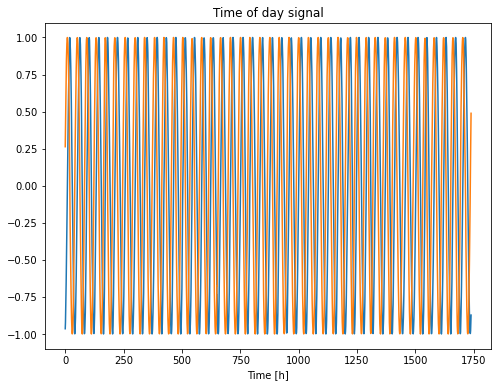

In [10]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
week = 0.25*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
df['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week))

plt.plot(np.array(df['Day sin']))
plt.plot(np.array(df['Day cos']))
plt.xlabel('Time [h]')
plt.title('Time of day signal')

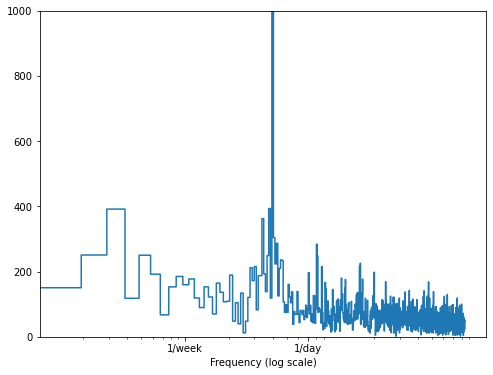

In [5]:
fft = tf.signal.rfft(df['People'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['People'])
hours_per_week = 24*7
weeks_per_dataset = n_samples_h/(hours_per_week)

f_per_week = f_per_dataset/weeks_per_dataset
plt.step(f_per_week, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 1000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 7], labels=['1/week', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [11]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [12]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

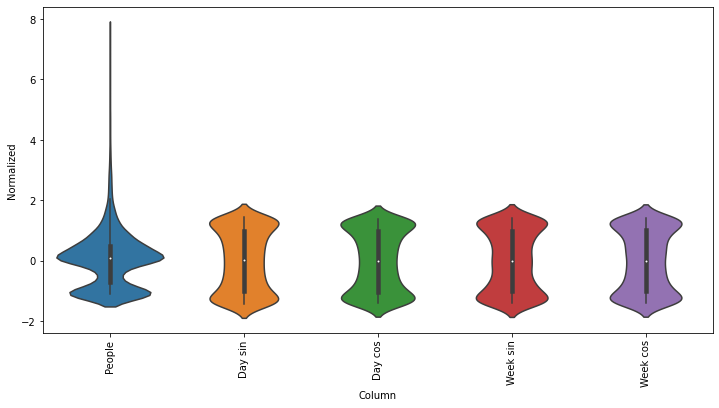

In [13]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [14]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
              train_df= train_df,val_df=val_df,test_df= test_df,
              label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [15]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['People'])
w1

    

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['People']

In [16]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['People'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['People']

In [17]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [18]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 5)
Inputs shape: (3, 6, 5)
labels shape: (3, 1, 1)


In [19]:
w2.example = example_inputs, example_labels

In [20]:
def plot(self, model=None, plot_col='People', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

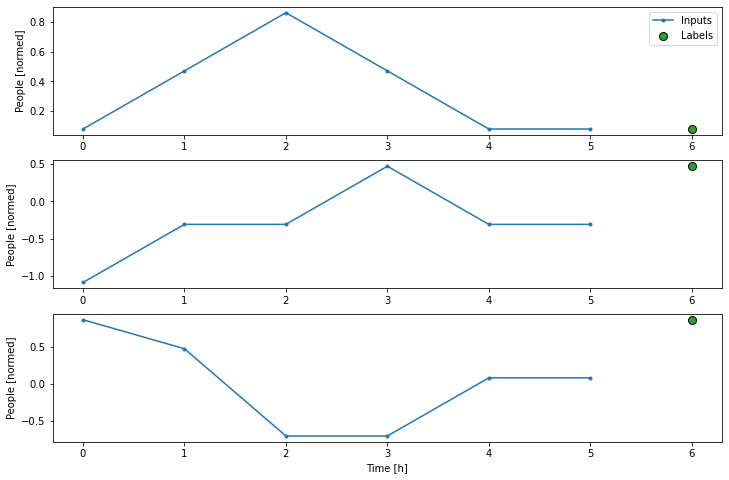

In [21]:
w2.plot()

In [22]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [23]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [24]:
# Each element is an (inputs, label) pair
w1.train.element_spec

Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['People']> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['People']> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(TensorSpec(shape=(None, 24, 5), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [25]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 5)
Labels shape (batch, time, features): (32, 1, 1)


In [26]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['People'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['People']

In [27]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 5)
Labels shape (batch, time, features): (32, 1, 1)


In [28]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [29]:
baseline = Baseline(label_index=column_indices['People'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
11/11 [==============================] - 0s 3ms/step - loss: 0.5057 - mean_absolute_error: 0.4917


In [30]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['People'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['People']

In [31]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 5)
Output shape: (32, 24, 1)


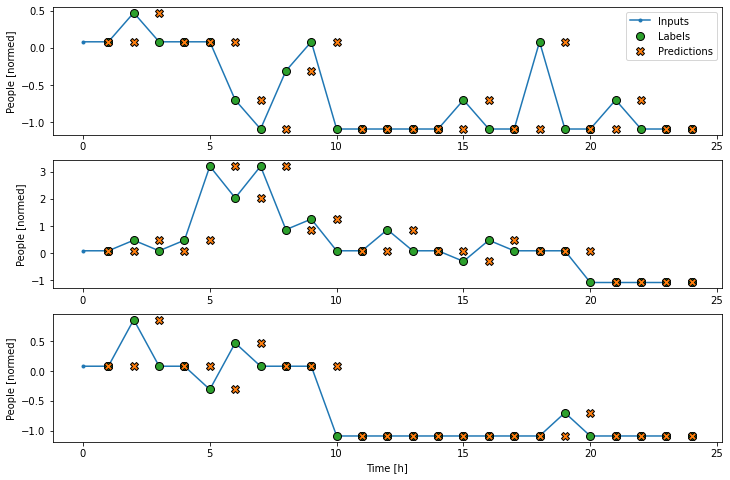

In [32]:
wide_window.plot(baseline)

In [33]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [34]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 5)
Output shape: (32, 1, 1)


In [36]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [37]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
39/39 [==============================] - 0s 10ms/step - loss: 2.6527 - mean_absolute_error: 1.3354 - val_loss: 2.5384 - val_mean_absolute_error: 1.3013
Epoch 2/20
39/39 [==============================] - 0s 7ms/step - loss: 2.4626 - mean_absolute_error: 1.2816 - val_loss: 2.3785 - val_mean_absolute_error: 1.2617
Epoch 3/20
39/39 [==============================] - 0s 6ms/step - loss: 2.2873 - mean_absolute_error: 1.2303 - val_loss: 2.2282 - val_mean_absolute_error: 1.2231
Epoch 4/20
39/39 [==============================] - 0s 5ms/step - loss: 2.1333 - mean_absolute_error: 1.1842 - val_loss: 2.0887 - val_mean_absolute_error: 1.1855
Epoch 5/20
39/39 [==============================] - 0s 6ms/step - loss: 1.9937 - mean_absolute_error: 1.1408 - val_loss: 1.9685 - val_mean_absolute_error: 1.1520
Epoch 6/20
39/39 [==============================] - 0s 5ms/step - loss: 1.8626 - mean_absolute_error: 1.0984 - val_loss: 1.8500 - val_mean_absolute_error: 1.1171
Epoch 7/20
39/39 [=========

In [38]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 5)
Output shape: (32, 24, 1)


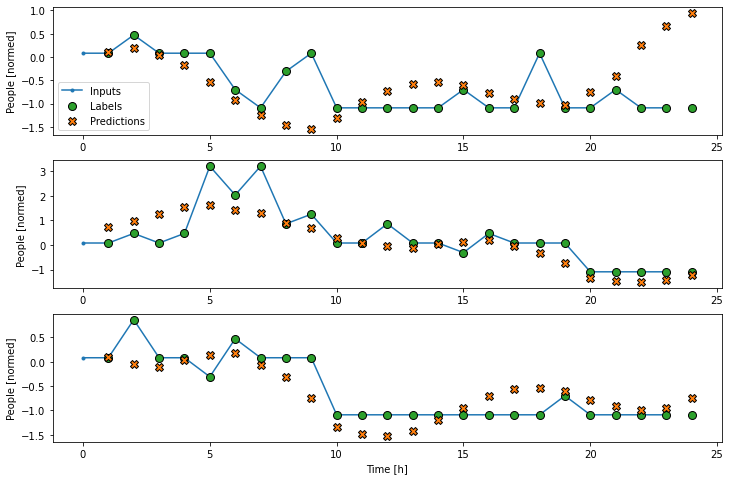

In [39]:
wide_window.plot(linear)

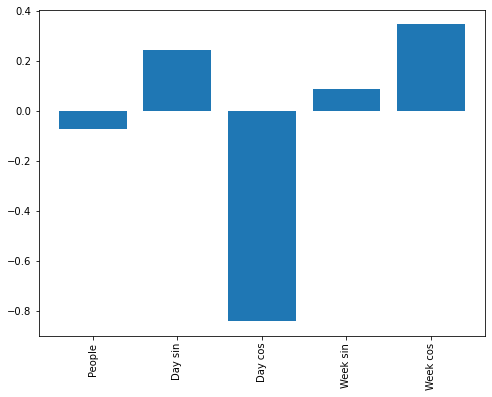

In [40]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [41]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
39/39 [==============================] - 1s 16ms/step - loss: 0.5977 - mean_absolute_error: 0.5530 - val_loss: 0.4144 - val_mean_absolute_error: 0.5009
Epoch 2/20
39/39 [==============================] - 0s 8ms/step - loss: 0.4000 - mean_absolute_error: 0.4510 - val_loss: 0.4147 - val_mean_absolute_error: 0.4958
Epoch 3/20
39/39 [==============================] - 0s 7ms/step - loss: 0.3865 - mean_absolute_error: 0.4438 - val_loss: 0.4104 - val_mean_absolute_error: 0.4962
Epoch 4/20
39/39 [==============================] - 0s 7ms/step - loss: 0.3811 - mean_absolute_error: 0.4420 - val_loss: 0.4286 - val_mean_absolute_error: 0.4939
Epoch 5/20
11/11 [==============================] - 0s 2ms/step - loss: 0.4232 - mean_absolute_error: 0.4997


In [42]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['People'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['People']

Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

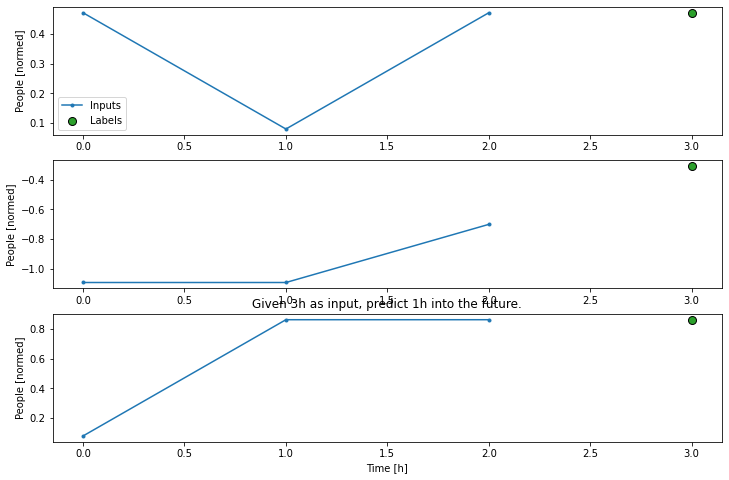

In [43]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

In [44]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [45]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 5)
Output shape: (32, 1, 1)


In [46]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

11/11 [==============================] - 0s 2ms/step - loss: 0.4133 - mean_absolute_error: 0.4975


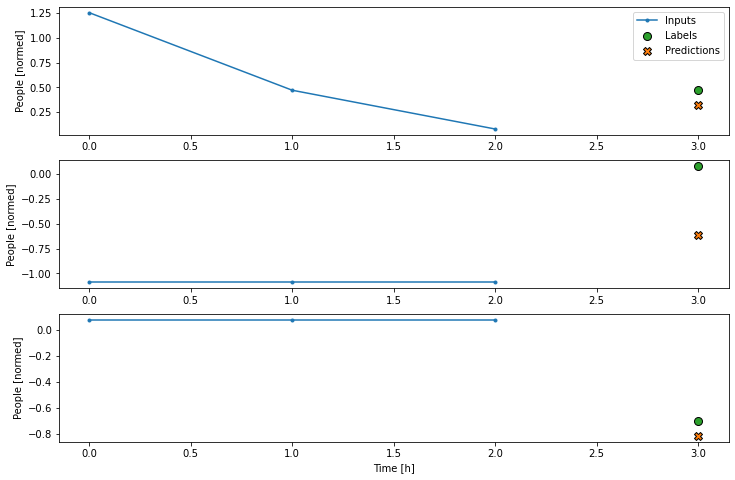

In [152]:
conv_window.plot(multi_step_dense)

In [47]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [48]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 5)
Output shape: (32, 1, 1)


In [49]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

11/11 [==============================] - 0s 2ms/step - loss: 0.4072 - mean_absolute_error: 0.5014


In [50]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 5)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [51]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['People'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['People']

In [52]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 5)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


ValueError: x and y can be no greater than 2-D, but have shapes (32,) and (32, 26, 5)

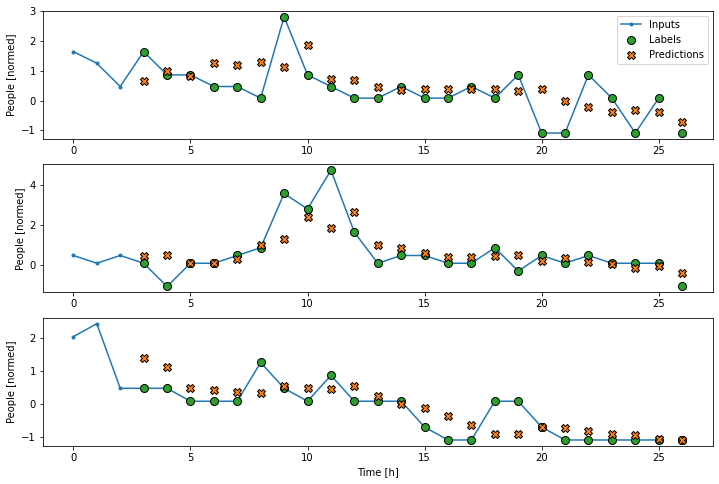

In [57]:
wide_conv_window.plot(conv_model)
tmp1 = (wide_conv_window.example[0]+train_mean)*train_std
tmp2 = (wide_conv_window.example[1]+train_mean)*train_std
plt.plot(tmp1)
plt.plot(tmp2)


In [160]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 5)
Output shape: (32, 24, 1)


In [161]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

wide_window.plot(lstm_model)

Epoch 1/20


NotImplementedError: in user code:

    C:\Users\tjmor\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\tjmor\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\tjmor\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\tjmor\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\tjmor\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\tjmor\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\tjmor\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    C:\Users\tjmor\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\tjmor\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:386 call
        outputs = layer(inputs, **kwargs)
    C:\Users\tjmor\Anaconda3\lib\site-packages\tensorflow\python\keras\layers\recurrent.py:663 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    C:\Users\tjmor\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\tjmor\Anaconda3\lib\site-packages\tensorflow\python\keras\layers\recurrent_v2.py:1108 call
        inputs, initial_state, _ = self._process_inputs(inputs, initial_state, None)
    C:\Users\tjmor\Anaconda3\lib\site-packages\tensorflow\python\keras\layers\recurrent.py:862 _process_inputs
        initial_state = self.get_initial_state(inputs)
    C:\Users\tjmor\Anaconda3\lib\site-packages\tensorflow\python\keras\layers\recurrent.py:645 get_initial_state
        init_state = get_initial_state_fn(
    C:\Users\tjmor\Anaconda3\lib\site-packages\tensorflow\python\keras\layers\recurrent.py:2523 get_initial_state
        return list(_generate_zero_filled_state_for_cell(
    C:\Users\tjmor\Anaconda3\lib\site-packages\tensorflow\python\keras\layers\recurrent.py:2968 _generate_zero_filled_state_for_cell
        return _generate_zero_filled_state(batch_size, cell.state_size, dtype)
    C:\Users\tjmor\Anaconda3\lib\site-packages\tensorflow\python\keras\layers\recurrent.py:2984 _generate_zero_filled_state
        return nest.map_structure(create_zeros, state_size)
    C:\Users\tjmor\Anaconda3\lib\site-packages\tensorflow\python\util\nest.py:635 map_structure
        structure[0], [func(*x) for x in entries],
    C:\Users\tjmor\Anaconda3\lib\site-packages\tensorflow\python\util\nest.py:635 <listcomp>
        structure[0], [func(*x) for x in entries],
    C:\Users\tjmor\Anaconda3\lib\site-packages\tensorflow\python\keras\layers\recurrent.py:2981 create_zeros
        return array_ops.zeros(init_state_size, dtype=dtype)
    C:\Users\tjmor\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\tjmor\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py:2747 wrapped
        tensor = fun(*args, **kwargs)
    C:\Users\tjmor\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py:2794 zeros
        output = _constant_if_small(zero, shape, dtype, name)
    C:\Users\tjmor\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py:2732 _constant_if_small
        if np.prod(shape) < 1000:
    <__array_function__ internals>:5 prod
        
    C:\Users\tjmor\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3030 prod
        return _wrapreduction(a, np.multiply, 'prod', axis, dtype, out,
    C:\Users\tjmor\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87 _wrapreduction
        return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
    C:\Users\tjmor\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:845 __array__
        raise NotImplementedError(

    NotImplementedError: Cannot convert a symbolic Tensor (sequential_20/lstm_8/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported


In [67]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

ValueError: 'mean_absolute_error' is not in list